In [1]:
from __future__ import print_function
import zipfile
import os

import argparse
from tqdm import tqdm
import os
import PIL.Image as Image

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import copy

import easydict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')

Using device: cuda

GeForce GTX 1070
Memory Usage:
Allocated: 0.0 MB
Cached:    0.0 MB


In [3]:
def initialize_data(folder):
    train_zip = folder + '/train_images.zip'
    test_zip = folder + '/test_images.zip'
    if not os.path.exists(train_zip) or not os.path.exists(test_zip):
        raise(RuntimeError("Could not find " + train_zip + " and " + test_zip
              + ', please download them from https://www.kaggle.com/c/nyu-cv-fall-2018/data '))
    # extract train_data.zip to train_data
    train_folder = folder + '/train_images'
    if not os.path.isdir(train_folder):
        print(train_folder + ' not found, extracting ' + train_zip)
        zip_ref = zipfile.ZipFile(train_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()
    # extract test_data.zip to test_data
    test_folder = folder + '/test_images'
    if not os.path.isdir(test_folder):
        print(test_folder + ' not found, extracting ' + test_zip)
        zip_ref = zipfile.ZipFile(test_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()

    # make validation_data by using images 00000*, 00001* and 00002* in each class
    val_folder = folder + '/val_images'
    if not os.path.isdir(val_folder):
        print(val_folder + ' not found, making a validation set')
        os.mkdir(val_folder)
        for dirs in os.listdir(train_folder):
            if dirs.startswith('000'):
                os.mkdir(val_folder + '/' + dirs)
                for f in os.listdir(train_folder + '/' + dirs):
                    if f.startswith('00000') or f.startswith('00001') or f.startswith('00002'):
                        # move file to validation folder
                        os.rename(train_folder + '/' + dirs + '/' + f, val_folder + '/' + dirs + '/' + f)

In [4]:
address = 'D:/Sync/Courses/Level_3/CV/Courant-CSCI-2271-Computer-Vision/Assignment_2'
initialize_data(address)

data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

args = easydict.EasyDict({
    'batch_size': 64,
    'epochs':100,
    'lr':0.00005,
    'momentum':0.5,
    'seed':1,
    'log_interval':100,
    'weight_decay':1e-2
})

kwargs = {'num_workers': 12, 'pin_memory': True}

torch.manual_seed(args.seed)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(address + '/train_images',
                         transform=data_transforms),
    batch_size=args.batch_size, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(address + '/val_images',
                         transform=data_transforms),
    batch_size=args.batch_size, shuffle=False, **kwargs)

In [6]:
class Inception(nn.Module):
    """ Reference:
    GoogLeNet: 
    Going Deeper with Convolutions
    https://arxiv.org/abs/1409.4842v1
    Github Reference: https://github.com/xuchaoxi/pytorch-classification/blob/master/models/googlenet.py
    """
    def __init__(self, in_channels, _1x1_, _3x3reduce_, _3x3_, _5x5reduce_, _5x5_, pool_proj):
        super(Inception, self).__init__()
        self.con1x1 = nn.Sequential(
            nn.Conv2d(in_channels, _1x1_, kernel_size=1),
            nn.BatchNorm2d(_1x1_),
            nn.ReLU(True),
        )
        self.con1x1_3x3 = nn.Sequential(
            nn.Conv2d(in_channels, _3x3reduce_, kernel_size=1),
            nn.BatchNorm2d(_3x3reduce_),
            nn.ReLU(True),
            nn.Conv2d(_3x3reduce_, _3x3_, kernel_size=3, padding=1),
            nn.BatchNorm2d(_3x3_),
            nn.ReLU(True),
            #nn.Conv2d(_3x3_, _3x3_, kernel_size=3, padding=1),
            #nn.BatchNorm2d(_3x3_),
            #nn.ReLU(True),
        )
        self.con1x1_5x5 = nn.Sequential(
            nn.Conv2d(in_channels, _5x5reduce_, kernel_size=1),
            nn.BatchNorm2d(_5x5reduce_),
            nn.ReLU(True),
            nn.Conv2d(_5x5reduce_, _5x5_, kernel_size=3, padding=1),
            nn.BatchNorm2d(_5x5_),
            nn.ReLU(True),
            nn.Conv2d(_5x5_, _5x5_, kernel_size=3, padding=1),
            nn.BatchNorm2d(_5x5_),
            nn.ReLU(True),
        )
        self.mp3x3_con1x1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, pool_proj, kernel_size = 1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True),
        )
    def forward(self, inputs):
        output_con1x1 = self.con1x1(inputs)
        output_con1x1_3x3 = self.con1x1_3x3(inputs)
        output_con1x1_5x5 = self.con1x1_5x5(inputs)
        output_mp3x3_con1x1 = self.mp3x3_con1x1(inputs)
        output = torch.cat([output_con1x1,output_con1x1_3x3,output_con1x1_5x5,output_mp3x3_con1x1], dim=1)
        return output


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self._3a = Inception(192,  64,  96, 128, 16, 32, 32)
        self._3b = Inception(256, 128, 128, 192, 32, 96, 64)

        self._4a = Inception(480, 192,  96, 208, 16,  48,  64)
        self._4b = Inception(512, 160, 112, 224, 24,  64,  64)
        self._4c = Inception(512, 128, 128, 256, 24,  64,  64)
        self._4d = Inception(512, 112, 144, 288, 32,  64,  64)
        self._4e = Inception(528, 256, 160, 320, 32, 128, 128)

        self._5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self._5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.dropout = nn.Dropout2d(0.4)
        self.linear = nn.Linear(1024, 43)
    def forward(self, input):
        output_pl = self.pre_layers(input)
        output_3a = self._3a(output_pl)
        output_3b = self._3b(output_3a)
        output_mp1 = self.maxpool(output_3b)
        output_4a = self._4a(output_mp1)
        output_4b = self._4b(output_4a)
        output_4c = self._4c(output_4b)
        output_4d = self._4d(output_4c)
        output_4e = self._4e(output_4d)
        output_mp2 = self.maxpool(output_4e)
        output_5a = self._5a(output_mp2)
        output_5b = self._5b(output_5a)
        output_ap = self.avgpool(output_5b)
        output_drop = self.dropout(output_ap)
        output_ = output_drop.view(output_drop.size(0), -1)
        output_ = self.linear(output_)
        return output_

In [7]:
### Neural Network and Optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
model = GoogLeNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr,weight_decay=0.01)

In [9]:
def train(epoch):
    # This is an updated function which is not the one that used to train
    # The one used to train in the following cell has a little bit of problem:
    # I store the wrong value as the training_accuracy in the previous version
    # That's why I cannot give the training_accuracy plot for this model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        train_loss = F.cross_entropy(output,target).to(device)
        train_loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()))
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        training_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss.item(), training_accuracy
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        validation_loss += F.cross_entropy(output,target).to(device).item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(val_loader.dataset)
    validation_accuracy = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset), validation_accuracy))
    return validation_loss, validation_accuracy

This is an updated function which is not the one that used to train.  

The one used to train in the following cell has a little bit of problem:

I store the wrong value as the training_accuracy in the previous version.  

That's why I cannot give the training_accuracy plot for this model.

In [8]:
train_loss_log = []
training_accuracy_log = []
validation_loss_log = []
validation_accuracy_log = []
for epoch in range(1, args.epochs + 1):
    train_loss, training_accuracy = train(epoch)
    validation_loss, validation_accuracy = validation() 
    
    train_loss_log.append(train_loss)
    training_accuracy_log.append(training_accuracy)
    validation_loss_log.append(validation_loss)
    validation_accuracy_log.append(validation_accuracy)
    torch.save(model.state_dict(), "model_GoogLeNet_2.pth")

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.816276
Train Epoch: 1 [6400/35339 (18%)]	Loss: 2.370297
Train Epoch: 1 [12800/35339 (36%)]	Loss: 2.321045
Train Epoch: 1 [19200/35339 (54%)]	Loss: 1.324392
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.811110
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.518370

Validation set: Average loss: 0.0325, Accuracy: 1676/3870 (43%)

Train Epoch: 2 [0/35339 (0%)]	Loss: 0.467572
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.261882
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.306955
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.200945
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.113898
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.143996

Validation set: Average loss: 0.0157, Accuracy: 2713/3870 (70%)

Train Epoch: 3 [0/35339 (0%)]	Loss: 0.142094
Train Epoch: 3 [6400/35339 (18%)]	Loss: 0.049988
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.031888
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.048624
Train Epoch: 3 [25600/35339 (72%)]	Loss: 0.050247
Train Epoch: 3 [32000/35339 (90%)]	L

Train Epoch: 45 [32000/35339 (90%)]	Loss: 0.000037

Validation set: Average loss: 0.0007, Accuracy: 3812/3870 (99%)

Train Epoch: 46 [0/35339 (0%)]	Loss: 0.000043
Train Epoch: 46 [6400/35339 (18%)]	Loss: 0.000023
Train Epoch: 46 [12800/35339 (36%)]	Loss: 0.000017
Train Epoch: 46 [19200/35339 (54%)]	Loss: 0.000014
Train Epoch: 46 [25600/35339 (72%)]	Loss: 0.000045
Train Epoch: 46 [32000/35339 (90%)]	Loss: 0.000014

Validation set: Average loss: 0.0007, Accuracy: 3813/3870 (99%)

Train Epoch: 47 [0/35339 (0%)]	Loss: 0.000021
Train Epoch: 47 [6400/35339 (18%)]	Loss: 0.000014
Train Epoch: 47 [12800/35339 (36%)]	Loss: 0.000029
Train Epoch: 47 [19200/35339 (54%)]	Loss: 0.000025
Train Epoch: 47 [25600/35339 (72%)]	Loss: 0.000006
Train Epoch: 47 [32000/35339 (90%)]	Loss: 0.000004

Validation set: Average loss: 0.0008, Accuracy: 3812/3870 (99%)

Train Epoch: 48 [0/35339 (0%)]	Loss: 0.000014
Train Epoch: 48 [6400/35339 (18%)]	Loss: 0.002355
Train Epoch: 48 [12800/35339 (36%)]	Loss: 0.000258
Trai

Train Epoch: 90 [12800/35339 (36%)]	Loss: 0.000006
Train Epoch: 90 [19200/35339 (54%)]	Loss: 0.000035
Train Epoch: 90 [25600/35339 (72%)]	Loss: 0.000021
Train Epoch: 90 [32000/35339 (90%)]	Loss: 0.000013

Validation set: Average loss: 0.0007, Accuracy: 3821/3870 (99%)

Train Epoch: 91 [0/35339 (0%)]	Loss: 0.000225
Train Epoch: 91 [6400/35339 (18%)]	Loss: 0.000014
Train Epoch: 91 [12800/35339 (36%)]	Loss: 0.000003
Train Epoch: 91 [19200/35339 (54%)]	Loss: 0.000005
Train Epoch: 91 [25600/35339 (72%)]	Loss: 0.000009
Train Epoch: 91 [32000/35339 (90%)]	Loss: 0.000003

Validation set: Average loss: 0.0006, Accuracy: 3816/3870 (99%)

Train Epoch: 92 [0/35339 (0%)]	Loss: 0.000002
Train Epoch: 92 [6400/35339 (18%)]	Loss: 0.000002
Train Epoch: 92 [12800/35339 (36%)]	Loss: 0.000015
Train Epoch: 92 [19200/35339 (54%)]	Loss: 0.000006
Train Epoch: 92 [25600/35339 (72%)]	Loss: 0.000005
Train Epoch: 92 [32000/35339 (90%)]	Loss: 0.000017

Validation set: Average loss: 0.0007, Accuracy: 3826/3870 (99%)

In [27]:
train_loss_log

[0.7924712896347046,
 0.3036676049232483,
 0.15681327879428864,
 0.5670299530029297,
 0.17080987989902496,
 0.106110118329525,
 0.003289439482614398,
 0.014851570129394531,
 0.00991006288677454,
 0.006531022023409605,
 0.03746071830391884,
 0.6588125824928284,
 0.005743720103055239,
 0.0031580491922795773,
 0.1905088871717453,
 0.37279650568962097,
 0.007019866723567247,
 0.0038097987417131662,
 0.030968492850661278,
 0.0012933991383761168,
 0.01674014888703823,
 0.14856475591659546,
 0.11762472987174988,
 0.0012252114247530699,
 0.009681441821157932,
 0.004074010066688061,
 0.0009423168958164752,
 0.0027260780334472656,
 0.0019452788401395082,
 0.005451679229736328,
 0.003414934268221259,
 9.146603406406939e-05,
 0.0027386925648897886,
 0.0191967710852623,
 0.0021269971039146185,
 0.0030279159545898438,
 0.007820823229849339,
 0.0008407505811192095,
 0.0008456490468233824,
 0.0003374706720933318,
 0.057292450219392776,
 0.038414619863033295,
 5.288557440508157e-05,
 0.0021356234792619

In [13]:
# Wrong training_accuracy_log
training_accuracy_log

[90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,
 90.41591320072332,


In [14]:
validation_loss_log

[0.03254980382434928,
 0.01573230876979594,
 0.010930789212963378,
 0.01038276885060993,
 0.00889364910391412,
 0.006721790338979519,
 0.0078048297557835435,
 0.014788404368923,
 0.006291105078884644,
 0.008057985230510241,
 0.006382588305431165,
 0.005101729992528035,
 0.003469952760482067,
 0.004693130377958468,
 0.0050291667064261995,
 0.0035693345576385156,
 0.0040146712764847345,
 0.003671506004127041,
 0.003041247164898098,
 0.002669155363291887,
 0.002266619340562501,
 0.002218251418640737,
 0.0017991341873164137,
 0.002096348637963906,
 0.0019732333123555425,
 0.0020691887222221822,
 0.001841602267779322,
 0.0017860149927790311,
 0.0016392674512703343,
 0.0018700475800296325,
 0.0008450486468637329,
 0.0006875159058150056,
 0.0008936468237155965,
 0.0013036450815228728,
 0.0018821849314934378,
 0.0018698370642798385,
 0.007247675898501732,
 0.0010191499066126578,
 0.0010546058978533007,
 0.0013498489282106013,
 0.0012682154323523558,
 0.0006377523128683545,
 0.00100389553075075

In [12]:
validation_accuracy_log

[43.30749354005168,
 70.10335917312662,
 81.52454780361757,
 81.96382428940568,
 85.01291989664082,
 87.57105943152455,
 86.66666666666667,
 81.98966408268734,
 89.50904392764858,
 87.67441860465117,
 89.17312661498708,
 92.19638242894057,
 93.87596899224806,
 91.65374677002583,
 92.09302325581395,
 93.69509043927648,
 93.69509043927648,
 94.67700258397933,
 94.70284237726098,
 95.32299741602067,
 96.07235142118863,
 96.2015503875969,
 96.69250645994832,
 96.02067183462532,
 96.40826873385014,
 96.27906976744185,
 96.5891472868217,
 96.4857881136951,
 96.82170542635659,
 96.4857881136951,
 98.03617571059432,
 98.78552971576228,
 98.11369509043928,
 97.82945736434108,
 96.77002583979328,
 96.38242894056847,
 90.62015503875969,
 97.77777777777777,
 97.59689922480621,
 97.41602067183463,
 97.57105943152455,
 98.75968992248062,
 97.95865633074935,
 98.29457364341086,
 98.50129198966408,
 98.52713178294573,
 98.50129198966408,
 96.74418604651163,
 98.11369509043928,
 98.44961240310077,
 98.

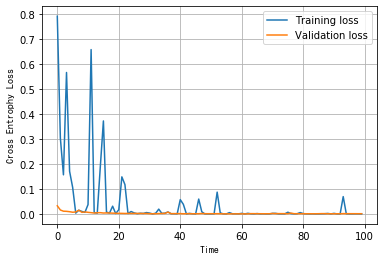

In [11]:
import matplotlib.pyplot as plt
time = list(range(100))
%matplotlib inline
plt.plot(time,train_loss_log)
plt.plot(time,validation_loss_log)
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.ylabel(u'Cross Entrophy Loss',fontproperties='SimHei')
plt.xlabel(u'Time',fontproperties='SimHei')

plt.grid(True)
plt.show()

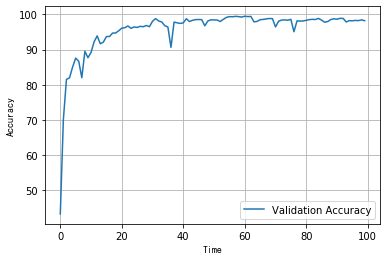

In [12]:
import matplotlib.pyplot as plt
time = list(range(100))

plt.plot(time,validation_accuracy_log)
plt.legend(['Validation Accuracy'], loc='lower right')
plt.ylabel(u'Accuracy',fontproperties='SimHei')
plt.xlabel(u'Time',fontproperties='SimHei')

plt.grid(True)
plt.show()